## Importing Libraries

In [746]:
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt
import scipy
from numpy.polynomial.chebyshev import chebval
from scipy.linalg import fractional_matrix_power

In [747]:
def generate_hermitian_matrix(M, choice=None):
    if choice == "random":
        """Generates an M x M random Hermitian matrix taking values from a normal distribution."""
        H = np.random.randn(M, M) + 1j * np.random.randn(M, M)
        H = 0.5 * (H + H.conj().T)  # Ensure Hermitian
        return H
    elif choice == "synthetic":
        """Generates a synthetic Hermitian matrix."""
        i, j = np.meshgrid(np.arange(M), np.arange(M), indexing="ij")
        H = np.exp(-0.5 * np.abs(i - j)) * np.sin(i + j)
        # H[np.abs(H) < 1e-5] = 0  # Set small values to zero
        return H
    else:
        raise ValueError("Invalid choice. Use 'random' or 'synthetic'.")

## Initializations

In [748]:
def Initialization(H, N, psi_0, subspace_choice, deltatau=1):
    """
    This function initializes the subspace for the algorithm.
    """
    M = H.shape[0]
    Psi_0 = np.empty((M, N), dtype=complex)

    if subspace_choice == 'random':
        # Generate a random orthonormal basis using QR decomposition
        Psi_0 = np.random.randn(M, N) + 1j * np.random.randn(M, N)
        Psi_0 /= np.linalg.norm(Psi_0, axis=0, keepdims=True)  # Normalize each column
        return Psi_0
    
    elif subspace_choice == 'chebyshev':
        T_prev = np.eye(M)
        T_curr = H
        Psi_0[:, 0] = psi_0.flatten()
        Psi_0[:, 1] = (T_curr @ psi_0).flatten()
        for i in range(2,N):
            T_next = 2 * H @ T_curr - T_prev
            T_prev, T_curr = T_curr, T_next
            Psi_0[:, i] = (T_curr @ psi_0).flatten()

        Psi_0 /= np.linalg.norm(Psi_0, axis=0, keepdims=True)
        return Psi_0
    
    elif subspace_choice == 'QRTE':
        eigenvalsh = np.sort(np.linalg.eigvalsh(H))
        deltaE_L = np.abs(eigenvalsh[N-1] - eigenvalsh[0]) # Some way to compute deltaE_L
        deltat = np.pi/deltaE_L
        exp_H = expm(- 1j * deltat * H)
        for i in range(N):
        # Shift the range to be from 0 to N-1
            i_n = i - N//2
            Psi_0[:, i] = (np.linalg.matrix_power(exp_H, i_n) @ psi_0).flatten()
        
        Psi_0 /= np.linalg.norm(Psi_0, axis=0, keepdims=True) # Not neessary since we are using a unitary operator anyways
        return Psi_0
    
    elif subspace_choice == 'QITE':
        exp_H = expm(- deltatau * H)
        for i in range(N):
            Psi_0[:, i] = (np.linalg.matrix_power(exp_H, i) @ psi_0).flatten()

        Psi_0 /= np.linalg.norm(Psi_0, axis=0, keepdims=True)
        return Psi_0
    else:
        raise ValueError("Invalid subspace choice. Use 'chebyshev', 'QRTE', or 'QITE' or 'random'.")

## Filtering

In [749]:
def filtering(H, Psi_0, N, filter_choice, deltatau=1, k=1):
    """
    This function applies a filter to the initial state Psi_0.
    """
    if filter_choice == 'none':
        return Psi_0
    
    elif filter_choice == 'QITE':
        # Apply QRTE filter
        exp_H =expm(- deltatau * H)
        Psi_F = exp_H @ Psi_0
        # Normalize the filtered state
        Psi_F /= np.linalg.norm(Psi_F, axis=0, keepdims=True)
        return Psi_F
    
    elif filter_choice == 'QRTE':
        # Apply QRTE filter
        eigenvalsh = np.sort(np.linalg.eigvalsh(H))
        deltaE_L = np.abs(eigenvalsh[N-1] - eigenvalsh[0])
        deltat = np.pi/deltaE_L
        exp_H = expm(- 1j * deltat * H)
        Psi_F = exp_H @ Psi_0
        # Normalize the filtered state
        Psi_F /= np.linalg.norm(Psi_F, axis=0, keepdims=True)
        return Psi_F
    
    elif filter_choice == 'chebyshev':
        # Apply Chebyshev filter
        M = H.shape[0]
        T_prev = np.eye(M)
        T_curr = H
        for i in range(2, k+1):
            T_next = 2 * H @ T_curr - T_prev
            T_prev, T_curr = T_curr, T_next

        Psi_F = T_curr @ Psi_0
        # Normalize the filtered state
        Psi_F /= np.linalg.norm(Psi_F, axis=0, keepdims=True)
        return Psi_F
    
    elif filter_choice == 'QITE_2':
        # Apply QITE filter
        exp_H = expm(- deltatau * H * H)
        Psi_F = exp_H @ Psi_0
        # Normalize the filtered state
        Psi_F /= np.linalg.norm(Psi_F, axis=0, keepdims=True)
        return Psi_F
    
    else:
        raise ValueError("Invalid filter choice. Use 'none', 'chebyshev', 'QRTE', 'QITE', or 'QITE_2'.")

## Normalization

In [750]:
def normalize(H, choice):
    if choice == 'none':
        return H
    elif choice == 'normal':
        # Normalize the matrix
        norm = np.linalg.norm(H, ord=2)
        return H / norm
    
    elif choice == 'norm01':
        eigvalsh = np.linalg.eigvalsh(H)
        a = np.min(eigvalsh) - 1e-6
        b = np.max(eigvalsh) + 1e-6
        H_normalized = (H - a * np.eye(H.shape[0])) / (b - a)
        return H_normalized
    else:
        raise ValueError("Invalid normalization choice. Use 'none', 'normal', or 'norm01'.")

### Diagonalization

In [751]:
def diagonalization(H, Psi_F):
    """
    This function diagonalizes the final state Psi_F.
    """
    # Projection Matrix
    H_proj = Psi_F.conj().T @ H @ Psi_F

    # Overlap Marix
    S = Psi_F.conj().T @ Psi_F

    # Regularization of the overlap matrix
    # try:
    #     eigenvals, eigenvecs = scipy.linalg.eigh(H_proj, S)
    # except np.linalg.LinAlgError:
    #     print("Matrix is not positive definite. Adding small value to diagonal for diagonalization")
    #     eps = 1e-10
    #     S += eps * np.eye(S.shape[0])
    #     eigenvals, eigenvecs = scipy.linalg.eigh(H_proj, S)

    eigenvals, eigenvecs = scipy.linalg.eigh(H_proj, S)
    
    return eigenvals, eigenvecs

def cholesky_factorization(Psi_F):
    # Overlap Matrix
    S = Psi_F.conj().T @ Psi_F
    # try:
    #     L = np.linalg.cholesky(S)
    # except np.linalg.LinAlgError:
    #     # If the matrix is not positive definite, add a small value to the diagonal
    #     print("Matrix is not positive definite. Adding small value to diagonal for cholesky factorization.")
    #     eps = 1e-10
    #     S += eps * np.eye(S.shape[0])
    #     L = np.linalg.cholesky(S)

    L = np.linalg.cholesky(S)
    
    return np.linalg.inv(L).conj().T


## Orthogonalization

In [752]:
def orthogonalization(Psi_F, eigenvecs):
    Psi_0 = Psi_F @ eigenvecs

    # Normalize the filtered state
    Psi_0 /= np.linalg.norm(Psi_0, axis=0, keepdims=True)
    return Psi_0

## Computing Error

In [753]:
def error(H, Psi_0, Ntilde, method, eigenvals):
    """
    This function calculates the error.
    """

    if method=='diagonalization':
        idx = np.argsort(eigenvals)
        eigenvals = eigenvals[idx]
        Psi_0 = Psi_0[:, idx]
        return np.max(np.linalg.norm(H @ Psi_0[:,:Ntilde] - Psi_0[:,:Ntilde] @ np.diag(eigenvals[:Ntilde]), axis=0, ord=2))
    
    elif method == 'cholesky':
        eigenvals = np.einsum('ji,jk,ki->i', Psi_0.conj(), H, Psi_0)
        idx = np.argsort(eigenvals)
        eigenvals = eigenvals[idx]
        Psi_0 = Psi_0[:,idx]

        return np.max(np.linalg.norm(H @ Psi_0[:,:Ntilde] - Psi_0[:,:Ntilde] @ np.diag(eigenvals[:Ntilde]), axis=0, ord=2))


    elif method == 'none':
        eigenvalsh = np.sort(np.linalg.eigvalsh(H))
        idx = np.argsort(eigenvals)
        eigenvals = eigenvals[idx]

        return np.linalg.norm(eigenvals[:Ntilde] - eigenvalsh[:Ntilde], ord=np.inf)
        
    else:
        raise ValueError("Invalid method. Use 'diagonalization' or 'cholesky' or 'none'.")

## Quantum Krylov Methods (QSMs)
### QITE

In [754]:
def QITE(H, psi_0, Ntilde, buffer, deltatau, epsilon, max_iter, filter_choice=False, orthogonalize=False):

    N = int(np.ceil((1+(buffer/100)) * Ntilde))

    H = normalize(H, choice='norm01')
    # H = normalize(H, choice='normal')

    itr = 0
    abs_error = [1e16]
    eigenvals = np.empty((N), dtype=complex)

    print()
    print("QITE Krylov basis No-Filter Diagonalization Parameters")
    print(f"Dimension of H matrix: {H.shape[0]}")
    print(f"Initial Space Size: {N}")
    print(f"Number of desired Eigenvalues: {Ntilde}")
    print(f"Buffer: {buffer}%")
    print(f"Tau: {deltatau}")
    print(f"Convergence Threshold: {epsilon}")
    print(f"Max Iterations: {max_iter}")
    print(f"Orthogonalize Matrix: {orthogonalize}")
    print()

    last_valid_eigenvals = None

    while itr < max_iter and abs_error[itr]>=epsilon and N <= H.shape[0]:
        
        # Initialization
        Psi_0 = Initialization(H, N, psi_0, subspace_choice='QITE', deltatau=deltatau)
        # print(f"Iteration {itr} Condition Number of Psi Matrix: {np.linalg.cond(Psi_0)}")

        # No Filtering
        if filter_choice:
            Psi_F = filtering(H, Psi_0, N, filter_choice='none')
        else:
            Psi_F = Psi_0

        # Orthogonalization
        if orthogonalize:
            try:
                L = cholesky_factorization(Psi_F)
                Psi_F = orthogonalization(Psi_F, L)
            except np.linalg.LinAlgError as e:
                print(f"Orthogonalizing Error at iteration {itr}: {str(e)}")
                print("Returning last successfully computed eigenvalues/eigenvectors.")
                return last_valid_eigenvals, abs_error, itr

        # Diagonalization
        try:
            eigenvals, _ = diagonalization(H, Psi_F)
        except np.linalg.LinAlgError as e:
            print(f"Diagonalization Error at iteration {itr}: {str(e)}")
            print("Returning last successfully computed eigenvalues/eigenvectors.")
            return last_valid_eigenvals, abs_error, itr
        
        # eigenvals, _ = diagonalization(H, Psi_F)
        # print(eigenvals[:Ntilde])
        # Compute Errors
        abs_error.append(error(H, Psi_0, Ntilde, method='none', eigenvals=eigenvals))

        last_valid_eigenvals = eigenvals

        N +=1
        itr+=1

    return eigenvals, abs_error, itr

### QRTE

In [755]:
def QRTE(H, psi_0, Ntilde, buffer, deltatau, epsilon, max_iter, filter_choice=False, orthogonalize=False):

    N = int(np.ceil((1+(buffer/100)) * Ntilde))

    H = normalize(H, choice='normal')
    itr = 0
    abs_error = [1e16]
    eigenvals = np.empty((N), dtype=complex)

    print()
    print("QRTE Krylov basis No-Filter Diagonalization Parameters")
    print(f"Dimension of H matrix: {H.shape[0]}")
    print(f"Initial Space Size: {N}")
    print(f"Number of desired Eigenvalues: {Ntilde}")
    print(f"Buffer: {buffer}%")
    print(f"Tau: {deltatau}")
    print(f"Convergence Threshold: {epsilon}")
    print(f"Max Iterations: {max_iter}")
    print(f"Orthogonalize Matrix: {orthogonalize}")
    print()

    last_valid_eigenvals = None

    while itr < max_iter and abs_error[itr]>=epsilon and N <= H.shape[0]:
        
        # Initialization
        Psi_0 = Initialization(H, N, psi_0, subspace_choice='QRTE', deltatau=deltatau)
        # print(f"Iteration {itr} Condition Number of Psi Matrix: {np.linalg.cond(Psi_0)}")

        # No Filtering
        if filter_choice:
            Psi_F = filtering(H, Psi_0, N, filter_choice='none')
        else:
            Psi_F = Psi_0

        # Orthogonalization
        if orthogonalize:
            try:
                L = cholesky_factorization(Psi_F)
                Psi_F = orthogonalization(Psi_F, L)
            except np.linalg.LinAlgError as e:
                print(f"Orthogonalizing Error at iteration {itr}: {str(e)}")
                print("Returning last successfully computed eigenvalues/eigenvectors.")
                return last_valid_eigenvals, abs_error, itr

        # Diagonalization
        try:
            eigenvals, _ = diagonalization(H, Psi_F)
        except np.linalg.LinAlgError as e:
            print(f"Diagonalization Error at iteration {itr}: {str(e)}")
            print("Returning last successfully computed eigenvalues/eigenvectors.")
            return last_valid_eigenvals, abs_error, itr
        
        # eigenvals, _ = diagonalization(H, Psi_F)
        # print(eigenvals[:Ntilde])
        # Compute Errors
        abs_error.append(error(H, Psi_0, Ntilde, method='none', eigenvals=eigenvals))

        last_valid_eigenvals = eigenvals

        N +=1
        itr+=1

    return eigenvals, abs_error, itr

### Chebyshev Quantum Krylov

In [756]:
def chebyshev(H, psi_0, Ntilde, buffer, deltatau, epsilon, max_iter, filter_choice=False, orthogonalize=False):

    N = int(np.ceil((1+(buffer/100)) * Ntilde))

    H = normalize(H, choice='normal')
    itr = 0
    abs_error = [1e16]
    eigenvals = np.empty((N), dtype=complex)

    print()
    print("Chebyshev Quantum Krylov basis No-Filter Diagonalization Parameters")
    print(f"Dimension of H matrix: {H.shape[0]}")
    print(f"Initial Space Size: {N}")
    print(f"Number of desired Eigenvalues: {Ntilde}")
    print(f"Buffer: {buffer}%")
    print(f"Tau: {deltatau}")
    print(f"Convergence Threshold: {epsilon}")
    print(f"Max Iterations: {max_iter}")
    print(f"Orthogonalize Matrix: {orthogonalize}")
    print()

    last_valid_eigenvals = None

    while itr < max_iter and abs_error[itr]>=epsilon and N <= H.shape[0]:
        
        # Initialization
        Psi_0 = Initialization(H, N, psi_0, subspace_choice='chebyshev', deltatau=deltatau)
        # print(f"Iteration {itr} Condition Number of Psi Matrix: {np.linalg.cond(Psi_0)}")

        # No Filtering
        if filter_choice:
            Psi_F = filtering(H, Psi_0, N, filter_choice='none')
        else:
            Psi_F = Psi_0

        # Orthogonalization
        if orthogonalize:
            try:
                L = cholesky_factorization(Psi_F)
                Psi_F = orthogonalization(Psi_F, L)
            except np.linalg.LinAlgError as e:
                print(f"Orthogonalizing Error at iteration {itr}: {str(e)}")
                print("Returning last successfully computed eigenvalues/eigenvectors.")
                return last_valid_eigenvals, abs_error, itr

        # Diagonalization
        try:
            eigenvals, _ = diagonalization(H, Psi_F)
        except np.linalg.LinAlgError as e:
            print(f"Diagonalization Error at iteration {itr}: {str(e)}")
            print("Returning last successfully computed eigenvalues/eigenvectors.")
            return last_valid_eigenvals, abs_error, itr
        
        # eigenvals, _ = diagonalization(H, Psi_F)
        # print(eigenvals[:Ntilde])
        # Compute Errors
        abs_error.append(error(H, Psi_0, Ntilde, method='none', eigenvals=eigenvals))

        last_valid_eigenvals = eigenvals

        N +=1
        itr+=1

    return eigenvals, abs_error, itr

## Our method

In [757]:
def method1(H, psi_0, Ntilde, buffer, deltatau, epsilon, max_iter, filter_choice=True, orthogonalize=True):

    N = int(np.ceil((1+(buffer/100)) * Ntilde))

    itr = 0
    abs_error = [1e16]
    eigenvals = np.empty((N), dtype=complex)
    

    print()
    print("QRTE Krylov basis with Filter Diagonalization Parameters")
    print(f"Dimension of H matrix: {H.shape[0]}")
    print(f"Initial Space Size: {N}")
    print(f"Number of desired Eigenvalues: {Ntilde}")
    print(f"Buffer: {buffer}%")
    print(f"Tau: {deltatau}")
    print(f"Convergence Threshold: {epsilon}")
    print(f"Max Iterations: {max_iter}")
    print(f"Orthogonalize Matrix: {orthogonalize}")
    print()

    last_valid_eigenvals = None
    last_valid_eigenvecs = None

    # Initialization
    H_norm = normalize(H, choice='normal')
    # H_norm = H
    Psi_0 = Initialization(H_norm, N, psi_0, subspace_choice='chebyshev', deltatau=deltatau)

    H = normalize(H, choice='norm01')
    
    while itr < max_iter and abs_error[itr]>=epsilon:
        
        # print(f"Iteration {itr} Condition Number of Psi Matrix: {np.linalg.cond(Psi_0)}")

        # No Filtering
        if filter_choice:
            Psi_F = filtering(H, Psi_0, N, filter_choice='QITE', deltatau=deltatau)
        else:
            Psi_F = Psi_0

        # Diagonalization
        try:
            eigenvals, eigenvecs = diagonalization(H, Psi_F)
        except np.linalg.LinAlgError as e:
            print(f"Diagonalization Error at iteration {itr}: {str(e)}")
            print("Returning last successfully computed eigenvalues/eigenvectors.")
            return last_valid_eigenvals, last_valid_eigenvecs, abs_error, itr
        
        # Orthogonalization
        if orthogonalize:
            try:
                Psi_0 = orthogonalization(Psi_F, eigenvecs)
            except np.linalg.LinAlgError as e:
                print(f"Orthogonalizing Error at iteration {itr}: {str(e)}")
                print("Returning last successfully computed eigenvalues/eigenvectors.")
                return last_valid_eigenvals, last_valid_eigenvecs, abs_error, itr
        
        # eigenvals, _ = diagonalization(H, Psi_F)
        # print(eigenvals[:Ntilde])
        # Compute Errors
        abs_error.append(error(H, Psi_0, Ntilde, method='none', eigenvals=eigenvals))

        last_valid_eigenvals = eigenvals
        last_valid_eigenvecs = eigenvecs
        itr+=1

    return eigenvals, eigenvecs, abs_error, itr

## Analysis

In [765]:
# Parameters
# np.random.seed(15) # For reproducibility
# np.random.seed(20)
M =  100 # Dimension of the matrix
Ntilde = 10  # Number of eigenvalues
buffer = 50  # Buffer for the number of eigenvalues
N = int(np.ceil((1+(buffer/100)) * Ntilde))  # Number of eigenvalues to be found
deltatau = 0.5 # Time step for the QITE method
filtertau = 10

epsilon = 1e-12  # Tolerance for convergence
max_iter = 500 # Maximum number of iterations

H = generate_hermitian_matrix(M, choice='synthetic')

# Normalize H so that the eigenvalues are in the range [0,1]
eigvalsh = np.linalg.eigvalsh(H)
a = np.min(eigvalsh) - 1e-6
b = np.max(eigvalsh) + 1e-6
# H = (H - a * np.eye(M)) / (b - a)
# print(H)
# Check if any of the value in H is greater than 1 or less than -1
# print(np.max(H), np.min(H))

# H = H / np.linalg.norm(H, ord=2)  # Normalize H to have a norm of 1

psi_0 = np.random.randn(M, 1) + 1j*np.random.randn(M, 1)
psi_0 /= np.linalg.norm(psi_0, axis=0, keepdims=True)
# print(psi_0)

print("Matrix Size: ", M)
print("Initial space size: ", N)
print("Number of Eigenvalues: ", Ntilde)
print("Buffer: ", buffer)
print("Time Step: ", deltatau)
print("Filter Time Step: ", filtertau)
print("Convergence Threshold: ", epsilon)
print("Max Iterations: ", max_iter)

Matrix Size:  100
Initial space size:  15
Number of Eigenvalues:  10
Buffer:  50
Time Step:  0.5
Filter Time Step:  10
Convergence Threshold:  1e-12
Max Iterations:  500


## Implementation

In [769]:
# qite_eigenvals, qite_abs_error, qite_itr = QITE(H, psi_0, Ntilde, buffer, deltatau, epsilon, max_iter, filter_choice=False, orthogonalize=False)
# qite_ortho_eigenvals, qite_ortho_abs_error, qite_ortho_itr = QITE(H, psi_0, Ntilde, buffer, deltatau, epsilon, max_iter, filter_choice=False, orthogonalize=True)
# qrte_eigenvals, qrte_abs_error, qrte_itr = QRTE(H, psi_0, Ntilde, buffer, deltatau, epsilon, max_iter, filter_choice=False, orthogonalize=False)
# qrte_ortho_eigenvals, qrte_ortho_abs_error, qrte_ortho_itr = QRTE(H, psi_0, Ntilde, buffer, deltatau, epsilon, max_iter, filter_choice=False, orthogonalize=True)
chebyshev_eigenvals, chebyshev_abs_error, chebyshev_itr = chebyshev(H, psi_0, Ntilde, buffer, deltatau, epsilon, max_iter, filter_choice=False, orthogonalize=False)
chebyshev_ortho_eigenvals, chebyshev_ortho_abs_error, chebyshev_ortho_itr = chebyshev(H, psi_0, Ntilde, buffer, deltatau, epsilon, max_iter, filter_choice=False, orthogonalize=True)
method1_eigenvals, method1_eigenvecs, method1_abs_error, method1_itr = method1(H, psi_0, Ntilde, buffer, filtertau, epsilon, max_iter, filter_choice=True, orthogonalize=True)


Chebyshev Quantum Krylov basis No-Filter Diagonalization Parameters
Dimension of H matrix: 100
Initial Space Size: 15
Number of desired Eigenvalues: 10
Buffer: 50%
Tau: 0.5
Convergence Threshold: 1e-12
Max Iterations: 500
Orthogonalize Matrix: False

Diagonalization Error at iteration 42: The leading minor of order 57 of B is not positive definite. The factorization of B could not be completed and no eigenvalues or eigenvectors were computed.
Returning last successfully computed eigenvalues/eigenvectors.

Chebyshev Quantum Krylov basis No-Filter Diagonalization Parameters
Dimension of H matrix: 100
Initial Space Size: 15
Number of desired Eigenvalues: 10
Buffer: 50%
Tau: 0.5
Convergence Threshold: 1e-12
Max Iterations: 500
Orthogonalize Matrix: True

Orthogonalizing Error at iteration 42: Matrix is not positive definite
Returning last successfully computed eigenvalues/eigenvectors.

QRTE Krylov basis with Filter Diagonalization Parameters
Dimension of H matrix: 100
Initial Space Size:

In [770]:
print("Printing Eigenvalues")
print("Original for QITE", np.sort(np.linalg.eigvalsh((H - a * np.eye(M)) / (b - a)))[:Ntilde])
# print("QITE:", qite_eigenvals[:Ntilde]) 
# print("QITE with Orthogonalization:", qite_ortho_eigenvals[:Ntilde])
print("Method 1:", method1_eigenvals[:Ntilde])
print()
print("Original for QRTE:",np.sort(np.linalg.eigvalsh(H/np.linalg.norm(H,ord=2)))[:Ntilde])
print("QRTE:", qrte_eigenvals[:Ntilde])
print("QRTE with Orthogonalization:", qrte_ortho_eigenvals[:Ntilde])
print("Chebyshev:", chebyshev_eigenvals[:Ntilde])
print("Chebyshev with Orthogonalization:", chebyshev_ortho_eigenvals[:Ntilde])

Printing Eigenvalues
Original for QITE [2.44100409e-07 5.24283597e-03 1.36918917e-02 2.47494740e-02
 4.07146138e-02 5.58346432e-02 7.31385174e-02 9.15366630e-02
 1.10531641e-01 1.29623799e-01]
Method 1: [2.44100409e-07 5.24283597e-03 1.36918917e-02 2.47494740e-02
 4.07146138e-02 5.58346432e-02 7.31385174e-02 9.15366630e-02
 1.10531641e-01 1.29623799e-01]

Original for QRTE: [-0.99991207 -0.98942734 -0.97252997 -0.95041576 -0.91848687 -0.88824813
 -0.85364188 -0.81684719 -0.77885889 -0.74067623]
QRTE: [-0.99991207 -0.98942734 -0.97252996 -0.95041576 -0.91848687 -0.88824813
 -0.85364188 -0.81684719 -0.77885889 -0.74067623]
QRTE with Orthogonalization: [-0.99991205 -0.98942734 -0.97252996 -0.95041575 -0.91848687 -0.88824813
 -0.85364188 -0.81684719 -0.77885889 -0.74067623]
Chebyshev: [-0.99991207 -0.98942734 -0.97252997 -0.95041576 -0.91848687 -0.88824813
 -0.85364188 -0.81684719 -0.77885889 -0.74067623]
Chebyshev with Orthogonalization: [-0.99991207 -0.98942734 -0.97252997 -0.95041576 -0

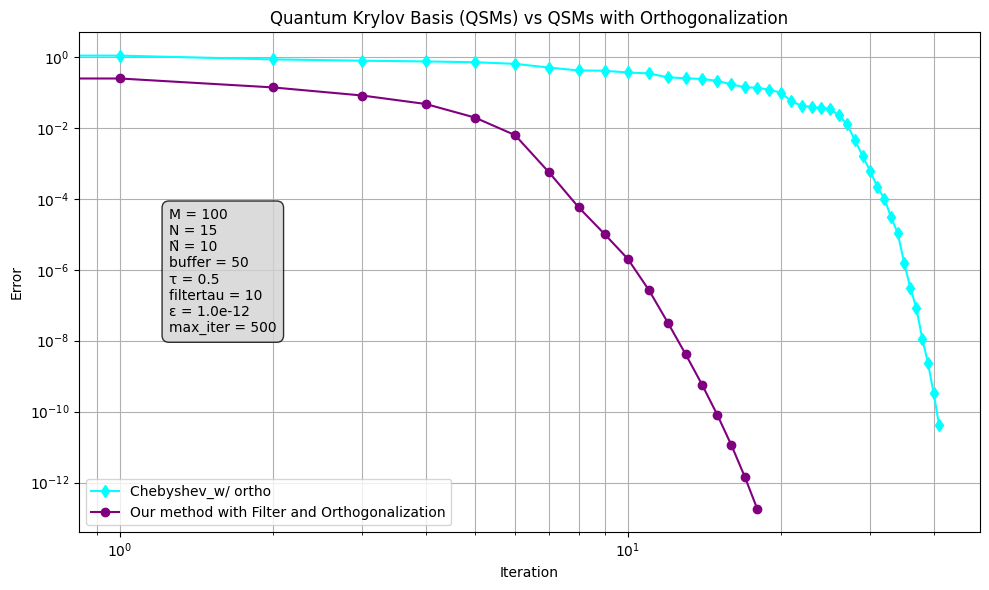

In [771]:
plt.figure(figsize=(10, 6))
plt.title('Quantum Krylov Basis (QSMs) vs QSMs with Orthogonalization')
# plt.plot(np.arange(qite_itr), qite_abs_error[1:], marker='o', label='QITE_w/o ortho', color='red')
# plt.plot(np.arange(qite_ortho_itr), qite_ortho_abs_error[1:], marker='^', label='QITE_w/ ortho', color='blue')
# plt.plot(np.arange(qrte_ortho_itr), qrte_ortho_abs_error[1:], marker='s', label='QRTE_w/ ortho', color='green')
# plt.plot(np.arange(qrte_itr), qrte_abs_error[1:], marker='x', label='QRTE_w/o ortho', color='orange')
plt.plot(np.arange(chebyshev_ortho_itr), chebyshev_ortho_abs_error[1:], marker='d', label='Chebyshev_w/ ortho', color='cyan')
# plt.plot(np.arange(chebyshev_itr), chebyshev_abs_error[1:], marker='*', label='Chebyshev_w/o ortho', color='magenta')
plt.plot(np.arange(method1_itr), method1_abs_error[1:], marker='o', label='Our method with Filter and Orthogonalization', color='purple')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.grid(True, 'both', 'both')
plt.legend()
info_text = (
    f"M = {M}\n"
    f"N = {N}\n"
    f"Ñ = {Ntilde}\n"
    f"buffer = {buffer}\n"
    f"τ = {deltatau}\n"
    f"filtertau = {filtertau}\n"
    f"ε = {epsilon:.1e}\n"
    f"max_iter = {max_iter}"
)

# Adjust position (x=0.65, y=0.5) as needed
plt.text(0.1, 0.4, info_text, transform=plt.gca().transAxes,
         fontsize=10, bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgrey', alpha=0.8))
plt.legend()
plt.tight_layout()
plt.show()